### Importing Utility Packages

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3 
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import tarfile, os
import numpy as np
import shutil

from google.colab import drive
drive.mount('/content/drive')

### Downloading Training Data to the Server

In [ ]:
!cp /content/drive/MyDrive/datasets-projeto/chexpert-v10-small.zip /content/
!unzip /content/chexpert-v10-small.zip
!rm /content/chexpert-v10-small.zip

!cp -r /content/drive/MyDrive/datasets-projeto/nih-files /content

extract_files = os.listdir('/content/nih-files')

for files in extract_files:
  print(f'Extraindo /content/nih-files/{files}')
  file_ = tarfile.open(f'/content/nih-files/{files}')
  file_.extractall('/content/')
  file_.close()
  os.remove(f'/content/nih-files/{files}')

!rm -r /content/nih-files

!cp /content/drive/MyDrive/datasets-projeto/vinbigdata-dataset.zip /content/
!unzip /content/vinbigdata-dataset.zip
!rm /content/vinbigdata-dataset.zip

### Organizing and Analyzing Data

In [4]:
dataset = pd.read_csv('/content/all_datasets.csv', index_col = 0)
dataset = dataset[((dataset['Opacity'] == 1.0) | 
                   (dataset['Atelectasis'] == 1.0) | 
                   (dataset['Pneumothorax'] == 1.0) | 
                   (dataset['Effusion'] == 1.0)) & 
                   (dataset['Nodule/Mass'] == 0.0) &
                   (dataset['No Finding'] == 0.0)].copy()

dataset.drop(labels = 'Nodule/Mass', axis = 1, inplace = True)
dataset.drop(labels = 'No Finding', axis = 1, inplace = True)
labels = ['Opacity', 'Atelectasis', 'Pneumothorax', 'Effusion']

Text(0, 0.5, 'Imagens')

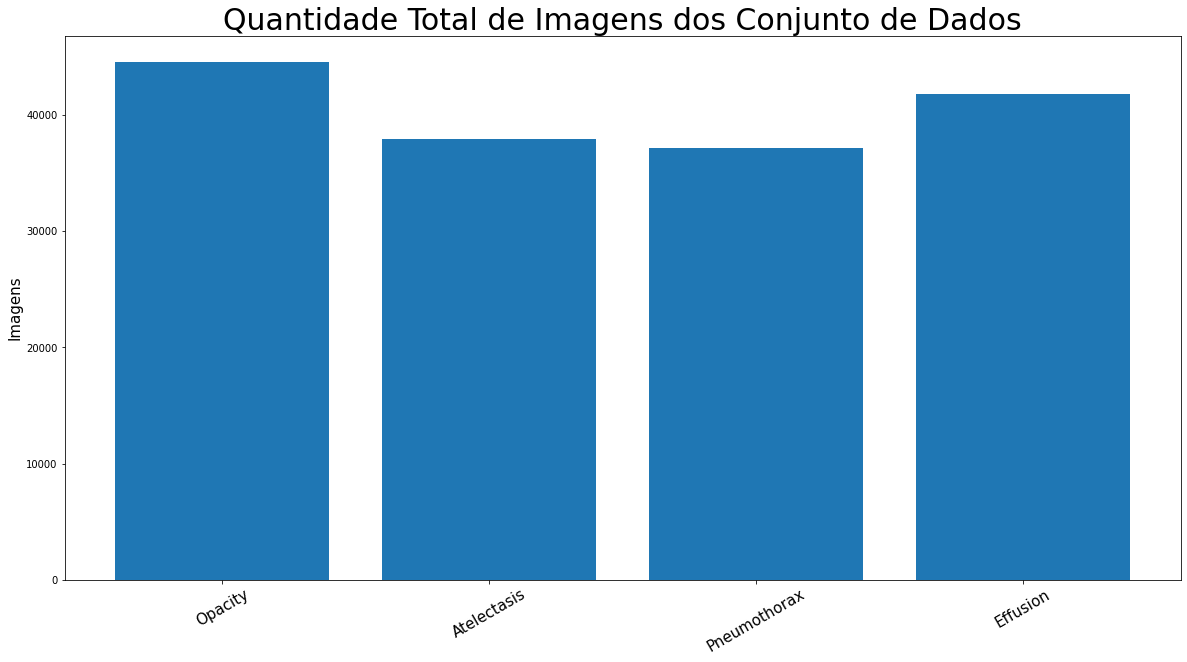

In [5]:
count_findings = list()
for finding in list(dataset.columns)[4:]:
  count = dict(dataset[finding].value_counts())[1.0]
  count_findings.append(count)

plt.figure(figsize = (20, 10))
plt.bar(list(dataset.columns)[4:], count_findings)
plt.xticks(rotation = 30, size = 15)
plt.title('Quantidade Total de Imagens dos Conjunto de Dados', size = 30)
plt.ylabel('Imagens', size = 15)

In [6]:
opacity = np.array(dataset['Opacity']).astype(str)
atelectasis = np.array(dataset['Atelectasis']).astype(str)
pneumothorax = np.array(dataset['Pneumothorax']).astype(str)
effusion = np.array(dataset['Effusion']).astype(str)

all_labels = np.zeros(effusion.shape).astype(str)
for index in range(0, len(opacity)):
  all_labels[index] = opacity[index] + atelectasis[index] + pneumothorax[index]
  all_labels[index] += effusion[index]

dataset['labels_ref'] = all_labels

In [7]:
f_train, f_val = train_test_split(dataset, test_size = 0.2, random_state = 42, 
                                  stratify = dataset['labels_ref'])
f_val, f_test = train_test_split(f_val, test_size = 0.5, random_state = 42, 
                                  stratify = f_val['labels_ref'])

f_train.drop(labels = ['labels_ref'], axis = 1, inplace = True)
f_val.drop(labels = ['labels_ref'], axis = 1, inplace = True)
f_test.drop(labels = ['labels_ref'], axis = 1, inplace = True)

Text(0, 0.5, 'Imagens')

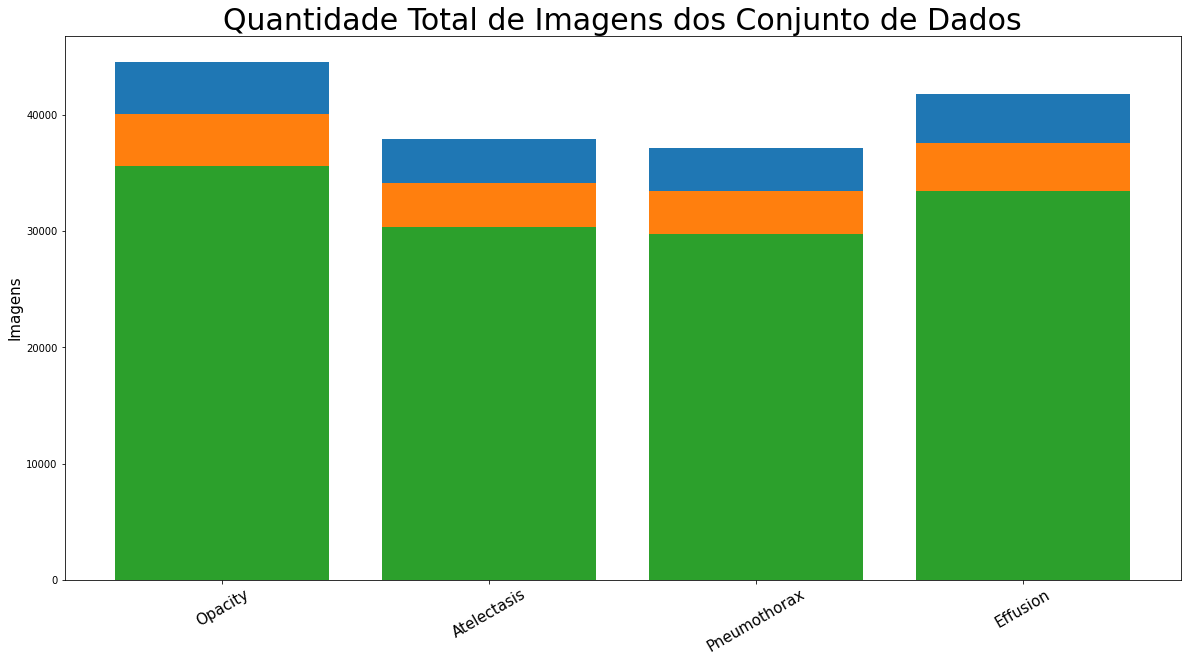

In [8]:
count_train, count_val, count_test = [], [], []
for finding in list(f_train.columns)[4:]:
  c_train = dict(f_train[finding].value_counts())[1.0]
  c_val = dict(f_val[finding].value_counts())[1.0]
  c_test = dict(f_test[finding].value_counts())[1.0]
  count_train.append(c_train), count_val.append(c_val), count_test.append(c_test)

plt.figure(figsize = (20, 10))
plt.bar(list(f_train.columns)[4:], np.sum((count_train, count_val, count_test), 
                                          axis = 0))
plt.bar(list(f_train.columns)[4:], np.sum((count_train, count_val), axis = 0))
plt.bar(list(f_train.columns)[4:], count_train)
plt.xticks(rotation = 30, size = 15)
plt.title('Quantidade Total de Imagens dos Conjunto de Dados', size = 30)
plt.ylabel('Imagens', size = 15)

### Keras Data Generator

In [9]:
image_size, batch_size = 256, 64
labels = ['Opacity', 'Atelectasis', 'Pneumothorax', 'Effusion']

In [10]:
core_idg = ImageDataGenerator(rescale = 1/255., 
                              shear_range = 0.1, zoom_range = 0.15,
                              rotation_range = 5, width_shift_range = 0.1, 
                              height_shift_range = 0.05, fill_mode = 'constant')

train_gen = core_idg.flow_from_dataframe(dataframe = f_train, directory = None, 
                                         x_col = 'Path', y_col = labels, 
                                         class_mode = 'raw', 
                                         batch_size = batch_size,
                                         target_size = (image_size, image_size), 
                                         shuffle = True)

core_idg = ImageDataGenerator(rescale = 1/255.)

valid_gen = core_idg.flow_from_dataframe(dataframe = f_val, directory = None, 
                                         x_col = 'Path',  y_col = labels, 
                                         class_mode = 'raw', 
                                         batch_size = batch_size,
                                         target_size = (image_size, image_size),
                                         shuffle = False)

test_gen = core_idg.flow_from_dataframe(dataframe = f_test, directory = None, 
                                        x_col = 'Path', y_col = labels, 
                                        class_mode = 'raw', batch_size = batch_size,
                                        target_size = (image_size, image_size),
                                        shuffle = False)

y_labels_valid = valid_gen.labels
y_labels_test = test_gen.labels

Found 70159 validated image filenames.
Found 8770 validated image filenames.
Found 8770 validated image filenames.


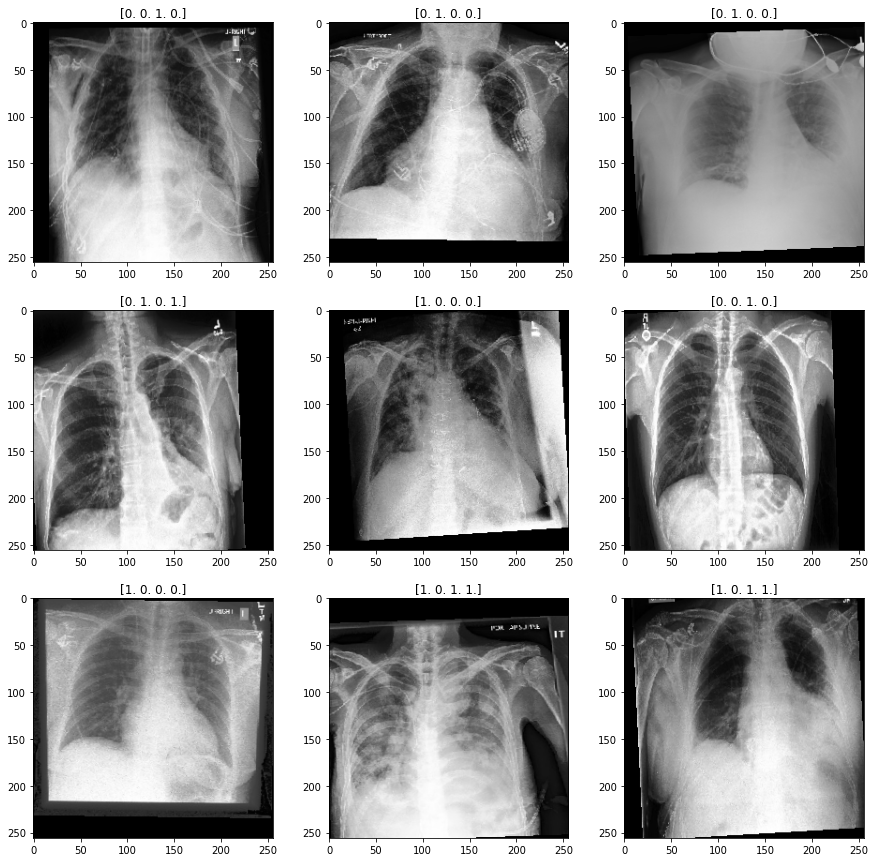

In [11]:
(x,y) = train_gen[0]
fig, axs = plt.subplots(3, 3, figsize = (15, 15))
count = 0
for i in range(0,3):
  for j in range(0,3):
    axs[i,j].set_title(str(y[count]))
    axs[i,j].imshow(x[count])
    count +=1

### Organizing a Callback Utility Function

In [ ]:
def get_callbacks(model_name, csv_filename, monitor = 'val_acc',):
    '''
    creates a list of useful callbacks for training the network

    Args:
        model_name (str) --> model name under review
        monitor (str) --> callback analysis metrics
        csv_filename (str) --> log csv file name

    Returns:
        callbacks (list) --> callback list
    '''
    checkpoint_file = f'model.{model_name}.h5'
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_file,
                                                    verbose = 1, 
                                                    save_best_only = True, 
                                                    monitor = monitor, 
                                                    mode = 'max')
    csv_logger = tf.keras.callbacks.CSVLogger(csv_filename, separator = ",", 
                                              append = False)
    
    return [checkpoint, csv_logger]

### Defining a Layer Freezing Method

In [ ]:
def freeze_layers(conv_base, layer_name):
  '''
  freeze layers of convolutional neural network training

  Args:
    conv_base (tensor) --> convolutional layers of the model
    layer_name (str) --> name of the freezing weight boundary layer
  '''

  conv_base.trainable = True
  set_trainable = False

  for layer in conv_base.layers:
    if layer.name == layer_name: set_trainable = True
    if set_trainable: layer.trainable = True
    else: layer.trainable = False
  
  return None

### InceptionV3

In [ ]:
base_model = InceptionV3(include_top = False, weights = 'imagenet', 
                         input_shape = (image_size, image_size, 3))
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output = tf.keras.layers.Dense(len(labels), activation = 'sigmoid')(x)
inception = tf.keras.Model(base_model.input, output)
inception.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
                 loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.0), 
                metrics = [tf.keras.metrics.AUC(multi_label = True)])

callbacks = get_callbacks('inception', 'inception.csv' ,'val_auc')

In [ ]:
layers_name = list()
for layer in base_model.layers:
  layers_name.append(layer.name)

block_names = ['input_1', 'activation_18', 'batch_normalization_30', 
               'conv2d_58', 'mixed8']

for blocks in block_names:
  try:
    layers_name.index(blocks)
    print('Bloco ' + blocks + ' found!')
  except ValueError:
    print('Bloco ' + blocks + ' not found!')

Bloco input_1 found!
Bloco activation_18 found!
Bloco batch_normalization_30 found!
Bloco conv2d_58 found!
Bloco mixed8 found!


In [ ]:
freeze_layers(conv_base = base_model, layer_name = block_names[4])
inception.summary()

In [ ]:
inception.fit(train_gen, steps_per_epoch = len(f_train) / batch_size,
              validation_data = valid_gen, epochs = 4, callbacks = callbacks,
              use_multiprocessing = True, workers = 8)

Epoch 1/4
1097/1096 [==============================] - ETA: 0s - loss: 0.5871 - auc: 0.7381
Epoch 1: val_auc improved from -inf to 0.70923, saving model to model.inception.h5
1096/1096 [==============================] - 670s 591ms/step - loss: 0.5871 - auc: 0.7381 - val_loss: 0.7873 - val_auc: 0.7092
Epoch 2/4
1097/1096 [==============================] - ETA: 0s - loss: 0.5521 - auc: 0.7769
Epoch 2: val_auc improved from 0.70923 to 0.76419, saving model to model.inception.h5
1096/1096 [==============================] - 637s 577ms/step - loss: 0.5521 - auc: 0.7769 - val_loss: 0.5723 - val_auc: 0.7642
Epoch 3/4
1097/1096 [==============================] - ETA: 0s - loss: 0.5340 - auc: 0.7937
Epoch 3: val_auc improved from 0.76419 to 0.77030, saving model to model.inception.h5
1096/1096 [==============================] - 639s 577ms/step - loss: 0.5340 - auc: 0.7937 - val_loss: 0.5795 - val_auc: 0.7703
Epoch 4/4
1097/1096 [==============================] - ETA: 0s - loss: 0.5210 - auc: 0.8

In [ ]:
inception.load_weights('/content/model.inception.h5')
inception.save('model_inception1')
!zip -r model_inception1.zip /content/model_inception1
shutil.move('/content/model_inception1.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification')

In [ ]:
freeze_layers(conv_base = base_model, layer_name = block_names[3])
inception.summary()

In [ ]:
inception.fit(train_gen, steps_per_epoch = len(f_train) / batch_size,
              validation_data = valid_gen, epochs = 4, callbacks = callbacks,
              use_multiprocessing = True, workers = 8)

Epoch 1/4
1097/1096 [==============================] - ETA: 0s - loss: 0.5229 - auc: 0.8038
Epoch 1: val_auc improved from 0.77030 to 0.77331, saving model to model.inception.h5
1096/1096 [==============================] - 639s 577ms/step - loss: 0.5229 - auc: 0.8038 - val_loss: 0.5845 - val_auc: 0.7733
Epoch 2/4
1097/1096 [==============================] - ETA: 0s - loss: 0.5090 - auc: 0.8154
Epoch 2: val_auc improved from 0.77331 to 0.78208, saving model to model.inception.h5
1096/1096 [==============================] - 639s 577ms/step - loss: 0.5090 - auc: 0.8154 - val_loss: 0.5833 - val_auc: 0.7821
Epoch 3/4
1097/1096 [==============================] - ETA: 0s - loss: 0.4961 - auc: 0.8260
Epoch 3: val_auc did not improve from 0.78208
1096/1096 [==============================] - 636s 575ms/step - loss: 0.4961 - auc: 0.8260 - val_loss: 0.5933 - val_auc: 0.7661
Epoch 4/4
1097/1096 [==============================] - ETA: 0s - loss: 0.4808 - auc: 0.8376
Epoch 4: val_auc improved from 0.

In [ ]:
inception.load_weights('/content/model.inception.h5')
inception.save('model_inception2')
!zip -r model_inception2.zip /content/model_inception2
shutil.move('/content/model_inception2.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification')

In [ ]:
freeze_layers(conv_base = base_model, layer_name = block_names[2])
inception.summary()

In [ ]:
inception.fit(train_gen, steps_per_epoch = len(f_train) / batch_size,
              validation_data = valid_gen, epochs = 4, callbacks = callbacks,
              use_multiprocessing = True, workers = 8)

Epoch 1/4
1097/1096 [==============================] - ETA: 0s - loss: 0.4648 - auc: 0.8494
Epoch 1: val_auc did not improve from 0.79752
1096/1096 [==============================] - 637s 575ms/step - loss: 0.4648 - auc: 0.8494 - val_loss: 0.5555 - val_auc: 0.7931
Epoch 2/4
1097/1096 [==============================] - ETA: 0s - loss: 0.4475 - auc: 0.8612
Epoch 2: val_auc improved from 0.79752 to 0.79802, saving model to model.inception.h5
1096/1096 [==============================] - 641s 580ms/step - loss: 0.4475 - auc: 0.8612 - val_loss: 0.5493 - val_auc: 0.7980
Epoch 3/4
1097/1096 [==============================] - ETA: 0s - loss: 0.4290 - auc: 0.8732
Epoch 3: val_auc did not improve from 0.79802
1096/1096 [==============================] - 638s 578ms/step - loss: 0.4290 - auc: 0.8732 - val_loss: 0.6159 - val_auc: 0.7964
Epoch 4/4
1097/1096 [==============================] - ETA: 0s - loss: 0.4080 - auc: 0.8857
Epoch 4: val_auc improved from 0.79802 to 0.82955, saving model to model.

In [ ]:
inception.load_weights('/content/model.inception.h5')
inception.save('model_inception3')
!zip -r model_inception3.zip /content/model_inception3
shutil.move('/content/model_inception3.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification')

In [ ]:
freeze_layers(conv_base = base_model, layer_name = block_names[1])
inception.summary()

In [ ]:
inception.fit(train_gen, steps_per_epoch = len(f_train) / batch_size,
              validation_data = valid_gen, epochs = 4, callbacks = callbacks,
              use_multiprocessing = True, workers = 8)

Epoch 1/4
1097/1096 [==============================] - ETA: 0s - loss: 0.3877 - auc: 0.8975
Epoch 1: val_auc improved from 0.82955 to 0.83703, saving model to model.inception.h5
1096/1096 [==============================] - 645s 583ms/step - loss: 0.3877 - auc: 0.8975 - val_loss: 0.5129 - val_auc: 0.8370
Epoch 2/4
1097/1096 [==============================] - ETA: 0s - loss: 0.3667 - auc: 0.9087
Epoch 2: val_auc did not improve from 0.83703
1096/1096 [==============================] - 650s 588ms/step - loss: 0.3667 - auc: 0.9087 - val_loss: 0.5471 - val_auc: 0.8249
Epoch 3/4
1097/1096 [==============================] - ETA: 0s - loss: 0.3462 - auc: 0.9189
Epoch 3: val_auc improved from 0.83703 to 0.84462, saving model to model.inception.h5
1096/1096 [==============================] - 647s 586ms/step - loss: 0.3462 - auc: 0.9189 - val_loss: 0.5144 - val_auc: 0.8446
Epoch 4/4
1097/1096 [==============================] - ETA: 0s - loss: 0.3272 - auc: 0.9278
Epoch 4: val_auc improved from 0.

In [ ]:
inception.load_weights('/content/model.inception.h5')
inception.save('model_inception4')
!zip -r model_inception4.zip /content/model_inception4
shutil.move('/content/model_inception4.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification')

In [ ]:
freeze_layers(conv_base = base_model, layer_name = block_names[0])
inception.summary()

In [ ]:
inception.fit(train_gen, steps_per_epoch = len(f_train) / batch_size,
              validation_data = valid_gen, epochs = 4, callbacks = callbacks,
              use_multiprocessing = True, workers = 8)

Epoch 1/4
1097/1096 [==============================] - ETA: 0s - loss: 0.3057 - auc: 0.9369
Epoch 1: val_auc did not improve from 0.84824
1096/1096 [==============================] - 636s 575ms/step - loss: 0.3057 - auc: 0.9369 - val_loss: 0.5234 - val_auc: 0.8462
Epoch 2/4
1097/1096 [==============================] - ETA: 0s - loss: 0.2893 - auc: 0.9436
Epoch 2: val_auc did not improve from 0.84824
1096/1096 [==============================] - 638s 575ms/step - loss: 0.2893 - auc: 0.9436 - val_loss: 0.6401 - val_auc: 0.8281
Epoch 3/4
1097/1096 [==============================] - ETA: 0s - loss: 0.2729 - auc: 0.9498
Epoch 3: val_auc improved from 0.84824 to 0.86218, saving model to model.inception.h5
1096/1096 [==============================] - 641s 580ms/step - loss: 0.2729 - auc: 0.9498 - val_loss: 0.5329 - val_auc: 0.8622
Epoch 4/4
1097/1096 [==============================] - ETA: 0s - loss: 0.2580 - auc: 0.9552
Epoch 4: val_auc did not improve from 0.86218
1096/1096 [================

In [ ]:
inception.load_weights('/content/model.inception.h5')
inception.save('model_inception5')
!zip -r model_inception5.zip /content/model_inception5
shutil.move('/content/model_inception5.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification')

In [ ]:
shutil.move('/content/model.inception.h5', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification')

In [ ]:
csv_log1 = pd.read_csv('/content/inception1.csv')
csv_log2 = pd.read_csv('/content/inception2.csv')
csv_log3 = pd.read_csv('/content/inception3.csv')
csv_log4 = pd.read_csv('/content/inception4.csv')
csv_log5 = pd.read_csv('/content/inception5.csv')

csv_log = pd.concat([csv_log1, csv_log2, csv_log3, 
                     csv_log4, csv_log5])

csv_log.reset_index(inplace = True)
csv_log.drop(['index', 'epoch'], axis = 1, inplace = True)
csv_log.to_csv(path_or_buf = 'inception_log.csv', sep = ',')

shutil.move('/content/inception_log.csv', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification')

### Evaluative Metrics of the Trained Model

In [12]:
def binarize_preds(pred_array, column, threshold):
  '''
  function that binarizes multi-label prediction labels from a threshold

  Args:
    pred_array (array) --> array with multi-label predictions
    column (int) --> column under analysis
    threshold (float) --> Binarization threshold for the column under analysis
  
  Returns:
    pred_bin (array) --> array with the binarized predictions of the column 
    under analysis
  '''
  per_100 = pred_array[:,column] * 100
  pred_bin = list()
  for value in per_100:
    if value >= threshold: pred_bin.append(1)
    else: pred_bin.append(0)
  
  return pred_bin

In [17]:
y_pred_val = inception.predict(valid_gen)
y_pred = inception.predict(test_gen)
print(f'AUC | Dados de Validação = {inception.evaluate(valid_gen)[1] * 100} %')
print(f'AUC | Dados de Teste = {inception.evaluate(test_gen)[1] * 100} %')

138/138 [==============================] - 66s 444ms/step - loss: 0.5329 - auc: 0.8622
AUC | Dados de Validação = 86.2176775932312 %
138/138 [==============================] - 62s 444ms/step - loss: 0.5050 - auc: 0.8711
AUC | Dados de Teste = 87.10612654685974 %


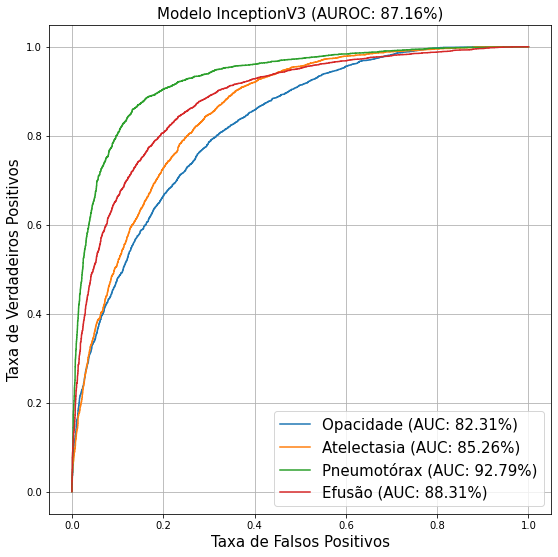

In [18]:
labels_portugues = ['Opacidade', 'Atelectasia', 'Pneumotórax', 'Efusão']
fig, c_ax = plt.subplots(1, 1, figsize = (9, 9))
for (idx, c_label) in enumerate(labels_portugues):
    fpr, tpr, thresholds = roc_curve(y_labels_test[:, idx].astype(int), y_pred[:, idx])
    c_ax.plot(fpr, tpr, label = '{} (AUC: {:.2f}%)'.format(c_label, auc(fpr, tpr) * 100))
c_ax.legend(fontsize = 15)
c_ax.set_xlabel('Taxa de Falsos Positivos', size = 15)
c_ax.set_ylabel('Taxa de Verdadeiros Positivos', size = 15)
auroc_value = str(roc_auc_score(y_labels_test.astype(int), y_pred)*100)[0:5]
c_ax.set_title('Modelo InceptionV3 (AUROC: ' + auroc_value + '%)', size = 15)
c_ax.grid(True)

In [19]:
threshold_variation = dict()
for label_index in range(0, len(labels)):
  threshold_variation[label_index] = list()
  for threshold in range(1, 100):
    y_pred_bin = binarize_preds(pred_array = y_pred_val, column = label_index, 
                                threshold = threshold)
    matrix = confusion_matrix(y_labels_valid[:, label_index], y_pred_bin)
    precision = matrix[0,0] / (matrix[0,0]+matrix[0,1])
    recall = matrix[0,0] / (matrix[0,0]+matrix[1,0])
    f1_score = (2 * precision*recall) / (precision + recall) 
    threshold_variation[label_index].append(f1_score)

bests_thresholds = list()
for label_index in range(0, len(labels)):
   for threshold in range(1, 100):
     if threshold_variation[label_index][threshold] == np.max(threshold_variation[label_index]):
       bests_thresholds.append(threshold)
       break

In [20]:
acc, precision, recall, f1_score = list(), list(), list(), list()
for label_index in range(0,4):
  y_pred_bin = binarize_preds(pred_array = y_pred, column = label_index, 
                              threshold = bests_thresholds[label_index])
  matrix = confusion_matrix(y_labels_test[:, label_index], y_pred_bin)
  acc.append((matrix[0,0] + matrix[1,1])/np.sum(matrix))
  precision.append(matrix[0,0]/(matrix[0,0]+matrix[0,1]))
  recall.append(matrix[0,0]/(matrix[0,0]+matrix[1,0]))
  f1_score.append((2*precision*recall) / (precision + recall))
  print(f'=={labels_portugues[label_index]}== \n{matrix},' 
        f' Threshold = {bests_thresholds[label_index]}'
        f'\nAcurácia = {acc[label_index]*100} % | Precisão = {precision[label_index]*100} % | '
        f'\nSensibilidade = {recall[label_index]*100} % | F1 Score = {f1_score[label_index]*100} %\n')

==Opacidade== 
[[3721  591]
 [1952 2506]], Threshold = 62
Acurácia = 71.00342075256556 % | Precisão = 86.29406307977736 % | 
Sensibilidade = 65.59139784946237 % | F1 Score = 74.53179769654481 %

==Atelectasia== 
[[4208  762]
 [1376 2424]], Threshold = 48
Acurácia = 75.62143671607754 % | Precisão = 84.66800804828974 % | 
Sensibilidade = 75.35816618911176 % | F1 Score = 79.74227780936137 %

==Pneumotórax== 
[[4627  425]
 [ 852 2866]], Threshold = 71
Acurácia = 85.43899657924744 % | Precisão = 91.58749010292954 % | 
Sensibilidade = 84.44971710166088 % | F1 Score = 87.87389611622828 %

==Efusão== 
[[3932  658]
 [1094 3086]], Threshold = 77
Acurácia = 80.02280501710376 % | Precisão = 85.66448801742919 % | 
Sensibilidade = 78.23318742538798 % | F1 Score = 81.78036605657239 %



In [4]:
print(f'Acurácia Média = {np.array(acc).mean()} %')
print(f'Precisão Média = {np.array(precision).mean()} %')
print(f'Sensibilidade Média = {np.array(recall).mean()} %')
print(f'F1 Score Médio = {np.array(f1_score).mean()} %')

Acurácia Média = 78.02166476624856 %
Precisão Média = 87.05351231210645 %
Sensibilidade Média = 75.90811714140575 %
F1 Score Médio = 80.98208441967671 %
